## construct model


In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torchsummary import summary

# define the model
class MLPerceptron(nn.Module):
    def __init__(self):
        super(MLPerceptron, self).__init__()
        input_size = 28 * 28
        hidden_size = 128
        output_size = 10
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)
        return x

# create GPU device (if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# instantiate the model
model = MLPerceptron() # multi-layer perceptron model

# move the model to the GPU (if available)
model.to(device)

summary(model, (1, 28 * 28))

# define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# download and load the data
dataset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
            Linear-2               [-1, 1, 128]          16,512
            Linear-3               [-1, 1, 128]          16,512
            Linear-4                [-1, 1, 10]           1,290
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.51
Estimated Total Size (MB): 0.52
----------------------------------------------------------------


## model training

In [6]:
from torch import optim
from torch.utils.data import DataLoader, random_split

# number of epochs
n_epochs = 30

# split the dataset into training and validation sets
training_size = int(0.8 * len(dataset))  # 80% for training
validation_size = len(dataset) - training_size  # 20% for validation
training_data, validation_data = random_split(dataset, [training_size, validation_size])

# create training and validation data loaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

# define loss criterion and optimizer
loss_criterion = nn.MSELoss() # mean squared error loss function
optimizer = optim.SGD(model.parameters(), lr=0.8) # stochaistic gradient descent

# training and validation
for epoch in range(n_epochs):
    # training
    model.train()
    training_loss = 0.0
    for inputs, labels in training_loader:
        # move inputs and labels to GPU (if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # reshape the inputs and forward pass
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)

        # transform labels to match the output shape
        labels = nn.functional.one_hot(labels, num_classes=10).float()

        # calculate loss
        loss = loss_criterion(outputs, labels)
        training_loss += loss.item()

        # backward pass and optimization
        loss.backward()
        optimizer.step()

    # calculate average loss over an epoch
    training_loss = training_loss / len(training_loader)

    # validation loss
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            # move inputs and labels to GPU (if available)
            inputs, labels = inputs.to(device), labels.to(device)

            inputs = inputs.view(inputs.shape[0], -1)
            outputs = model(inputs)
            labels = nn.functional.one_hot(labels, num_classes=10).float()
            loss = loss_criterion(outputs, labels)
            validation_loss += loss.item()
    validation_loss = validation_loss / len(validation_loader)        

    print('epoch: {} \ttraining loss: {:.6f} \tvalidation loss: {:.6f}'.format(epoch+1, training_loss, validation_loss))

epoch: 1 	training loss: 0.001772 	validation loss: 0.002003
epoch: 2 	training loss: 0.001627 	validation loss: 0.001992
epoch: 3 	training loss: 0.001430 	validation loss: 0.001569
epoch: 4 	training loss: 0.001337 	validation loss: 0.001637
epoch: 5 	training loss: 0.001203 	validation loss: 0.001717
epoch: 6 	training loss: 0.001063 	validation loss: 0.001728
epoch: 7 	training loss: 0.001038 	validation loss: 0.001711
epoch: 8 	training loss: 0.000930 	validation loss: 0.001680
epoch: 9 	training loss: 0.000845 	validation loss: 0.001585
epoch: 10 	training loss: 0.000775 	validation loss: 0.002223
epoch: 11 	training loss: 0.000799 	validation loss: 0.001642
epoch: 12 	training loss: 0.000708 	validation loss: 0.001723
epoch: 13 	training loss: 0.000662 	validation loss: 0.001673
epoch: 14 	training loss: 0.000634 	validation loss: 0.001649
epoch: 15 	training loss: 0.000578 	validation loss: 0.001703
epoch: 16 	training loss: 0.000546 	validation loss: 0.001516
epoch: 17 	traini

## model validation

In [7]:
# validation
model.eval()
correct = 0
total = 0
error_inputs = []
error_labels = []
error_predictions = []

with torch.no_grad():
    for inputs, labels in validation_loader:
        # move inputs and labels to GPU (if available)
        inputs, labels = inputs.to(device), labels.to(device)

        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        
        # get the predicted class for each sample in the batch
        _, predicted = torch.max(outputs, 1)
        
        # count total number of labels and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # store inputs, labels, and predictions where predictions are incorrect
        for i, label in enumerate(labels):
            if label != predicted[i]:
                error_labels.append(label.item())
                error_inputs.append(inputs[i])
                error_predictions.append(predicted[i].item())

# calculate the percentage of correct predictions
accuracy = correct / total * 100

print('model accuracy: {:.2f}% ({:d} of {:d})'.format(accuracy, correct, total))

model accuracy: 99.18% (11902 of 12000)


## plot example of a failed prediction

torch.Size([784])
model prediction: 9 	label: 8


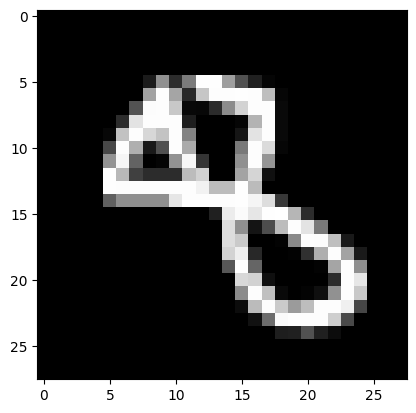

In [8]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

ind = 0
input = error_inputs[ind]
label = error_labels[ind]
prediction = error_predictions[ind]

print(input.size())

# unnormalize and reshape the image
image_tensor = (input * 0.5 + 0.5).reshape((28, 28))

# convert to PIL Image
image = to_pil_image(image_tensor)

print(f'model prediction: {prediction} \tlabel: {label}')

# display the image
plt.imshow(image, cmap='gray')
plt.show()


## save the model weights and biases

In [9]:
# save the model
from google.colab import drive
drive.mount('/content/gdrive')

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "/content/gdrive/My Drive/model.pth")

Mounted at /content/gdrive
